En el 1977, John W. Tukey escribe el libro "Exploratory Data Analysis", indicando el problema que había con la implicación en los Test de Hipótesis (CDA) y el poco EDA que había. 

Los objetivos del EDA son: 



*   Conseguir nuevos descubrimientos gracias a los datos.
*   Sugerir causas para los fenómenos.
*   Evaluar los supuestos de la inferencia estadística.
*   Ayudar a la creación de herramientas y técnicas apropiadas.
*   Dar una base para una mayor recopilación de datos con encuestas o experimentos.


Es por esto que se basa en transformar los datos, visualizarlos, analizar e interpretarlos y documentar.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Setup

## Import libraries

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Read data

In [3]:
train = pd.read_csv('train.csv',
                      na_values = "NA",
                      sep=",")
y_train = train['SalePrice']
X_train = train.drop(['SalePrice'], axis = 1)
X_test = pd.read_csv('test.csv',
                      na_values = "NA",
                      sep=",")
dataset = pd.concat([X_train, X_test]) 
dataset = dataset.drop(['Id'], axis = 1)

# Exploratory Data Analysis

## Información faltante
Empezamos por obtener en un data frame la cantidad de información faltante de cada columna tanto de los dato de entrenamiento como de los de pruebas:

In [4]:
missing_data = dataset.isnull().sum(axis = 0) #Generamos matriz booleana y sumamos los valores True por columnas
missing_data = missing_data[missing_data>0] #Filtramos las columnas con algún dato faltante
missing_data.sort_values(ascending = False) #Ordenamos las columnas

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [5]:
#Vemos que % de datos faltantes hay por cada columna

missing_data_percentage = missing_data/len(dataset)*100 #Calculamos el % del los datos faltantes en cada columna
missing_data_percentage.sort_values(ascending = False) #Ordenamos de mayor a menor


PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
MasVnrType      60.500171
FireplaceQu     48.646797
LotFrontage     16.649538
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
GarageYrBlt      5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrArea       0.787941
MSZoning         0.137033
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Functional       0.068517
Utilities        0.068517
GarageArea       0.034258
GarageCars       0.034258
Electrical       0.034258
KitchenQual      0.034258
TotalBsmtSF      0.034258
BsmtUnfSF        0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
dtype: float64

In [6]:
#Eliminamos todo lo que tenga más de un 20% de datos faltantes
def eliminar_cols_exceso_faltantes(data, missing_data_percentage, threshold):
    df = data
    for col in missing_data_percentage.index:
        if (missing_data_percentage[col])>threshold:
            df.drop(col, axis = 1, inplace = True)
    return df

dataset = eliminar_cols_exceso_faltantes(dataset, missing_data_percentage, 20)




In [7]:
#Comprobamos que no haya nada con más del 20% de datos faltantes en la base de datos remanente
percentage_of_missing = dataset.isnull().sum()/dataset.shape[0]*100
for i in range(len(percentage_of_missing)):
    if percentage_of_missing[i]>20:
        print('DANGER', percentage_of_missing[i])
    else:
        print('OK')

        

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


Vemos que existen variable con una gran cantidad de desinformación.

En la mayoría de los casos, se trata de que esa casa no posee una determinada instalación (por ejemplo, piscina), por lo que se ha dejado sin informar. Sin embargo, en los casos en los que la información es realmente faltante, se ha imputado la mediana o la moda por barrio, según sea la variable continua o discreta, respectivamente:


*   Reemplazamiento por la moda: MasVnrType, Functional, MSZoning, Utilities, Exterior1st, Exterior2nd, KitchenQual, SaleType.
*   Reemplazamiento por la mediana: LotFrontage, MasVnrArea


In [8]:
def impute_na(dataset, categorical_vars, numeric_vars, group_var='Neighborhood'):
    """
    Imputa los valores perdidos en un DataFrame, agrupando por una variable específica.

    Parámetros:
    dataset -- DataFrame de pandas con los datos
    categorical_vars -- lista de las variables categóricas a imputar
    numeric_vars -- lista de las variables numéricas a imputar
    group_var -- variable por la que agrupar para la imputación (por defecto 'Neighborhood')

    Retorna:
    Un DataFrame con los valores NA imputados.
    """
    imputed_data = dataset.copy()

    # Rellena los valores faltantes de las columnas categóricas con la moda
    for var in categorical_vars:
        imputed_data[var] = imputed_data.groupby(group_var)[var].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

    # Rellena los valores faltantes de las columnas numéricas con la mediana
    for var in numeric_vars:
        imputed_data[var] = imputed_data.groupby(group_var)[var].transform(lambda x: x.fillna(x.median()))

    return imputed_data

# Lista de variables categóricas y numéricas
categorical_vars = [ 'Functional', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']
numeric_vars = ['LotFrontage', 'MasVnrArea']

# Uso de la función para imputar los valores NA
dataset_imputed = impute_na(dataset, categorical_vars, numeric_vars)



<Axes: >

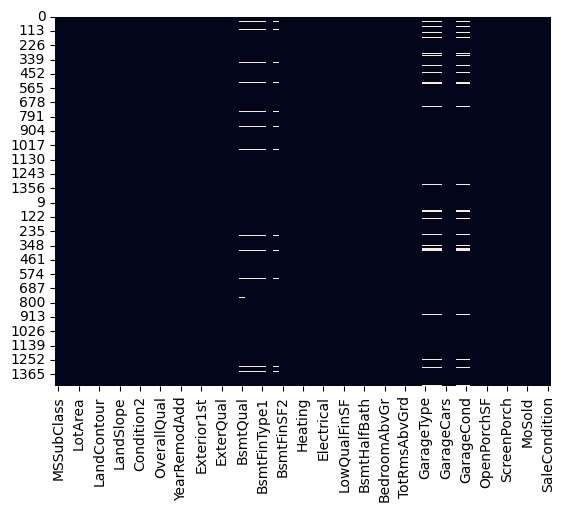

In [9]:
sns.heatmap(dataset_imputed.isnull(), cbar=False) #Hacemos un mapa de calor con los datos faltantes de esta base de datos

In [10]:
#Analizamos la columna que sigue conteniendo datos faltantes
missing_data_percentage = (dataset_imputed.isnull().sum()/dataset_imputed.shape[0])*100
missing_data_percentage.sort_values(ascending = False)

GarageYrBlt      5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
GarageType       5.378554
                   ...   
Foundation       0.000000
MSZoning         0.000000
HeatingQC        0.000000
CentralAir       0.000000
SaleCondition    0.000000
Length: 73, dtype: float64


Existen otras formas de reemplazar valores nulos, como puede ser por ejemplo usar un algoritmo cluster, que se abordarán en otro ejemplo de EDA.

*   Reemplazamiento por el valor cero (variables cuantitativas): GarageCars, GarageArea, BsmtFullBath, BsmtHalfBath, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF
*   Reemplazamiento por el valor 'None' (variables cualitativas): 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'




dataset_zero = dataset.drop(variables, axis = 1) #Filtramos todas las que no hemos escogido antes
dataset_zero.update(dataset_zero.select_dtypes(exclude=[np.number]).fillna('None')) #De las que quedan, excluimos las variables numéricas y rellenamos con 'None'
dataset_zero.update(dataset_zero.select_dtypes(include=[np.number]).fillna(0.0)) #De las que quedan, las numéricas las rellenamos con 0

Juntamos de nuevo toda la información

dataset = pd.concat([dataset_mode_median, dataset_zero], axis = 1) #Juntamos ambos dataset por columnas
X_train = dataset.loc[dataset.index.isin(X_train.index),:] #Filtramos los índices de datos de entrenamiento
X_test = dataset.loc[dataset.index.isin(X_test.index),:] #Filtramos los índices de datos test

*¡Ya no hay información faltante!*

missing_data = dataset.isnull().sum(axis = 0) #Generamos matriz booleana y sumamos los valores True por columnas
missing_data = missing_data[missing_data>0] #Filtramos las columnas con algún dato faltante
missing_data.sort_values(ascending = False) #Ordenamos las columnas

Finalmente, convertimos las variables tipo *int* a *float* para estudiarlas en la matriz de correlación:

dataset.loc[:,dataset.select_dtypes(include=np.number).columns] = (dataset.select_dtypes(include=np.number)).astype(float)

## Visualización

Veamos, en primer lugar, un estudio por densidad de la variable de respuesta, el precio de las casas en los datos de entrenamiento:

/tmp/ipykernel_168784/3659132393.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'] , fit=stats.norm); #Distribución de precios



 mu = 180921.20 and sigma = 79415.29



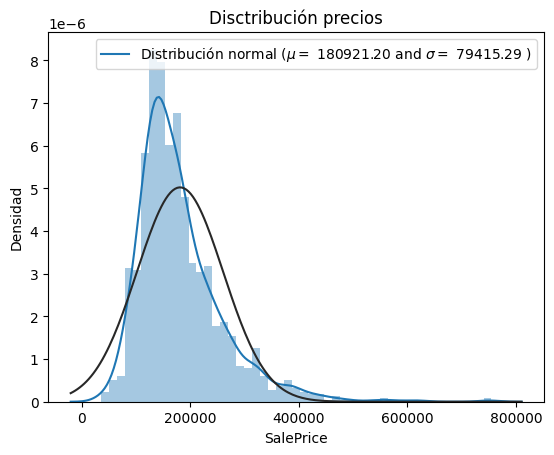

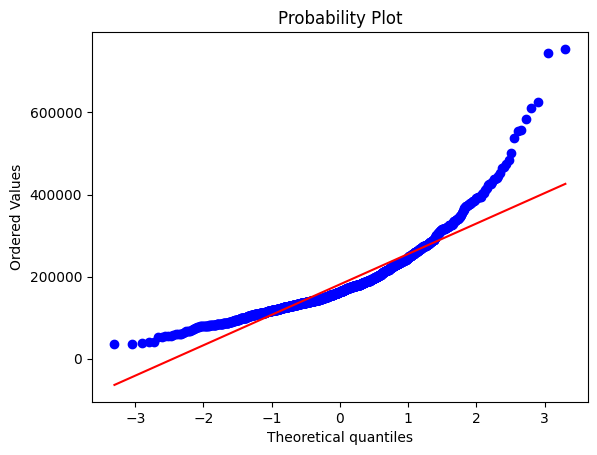

In [11]:
from scipy import stats
train_data = pd.concat([X_train, y_train], axis = 1) #Datos de entrenamiento

sns.distplot(train_data['SalePrice'] , fit=stats.norm); #Distribución de precios

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(train_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Distribución normal ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Densidad')
plt.title('Disctribución precios')

#Mostramos QQ-plot
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

Los modelos obtienen un comportamiento mucho más afinado cuando nuestra vairable respuesta posee un comportamiento normal, lo que motiva la siguiente transformación

/tmp/ipykernel_168784/308760403.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'] , fit=stats.norm);



 mu = 12.02 and sigma = 0.40



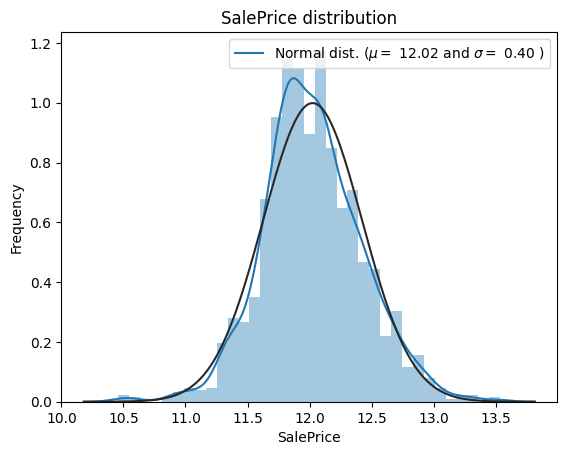

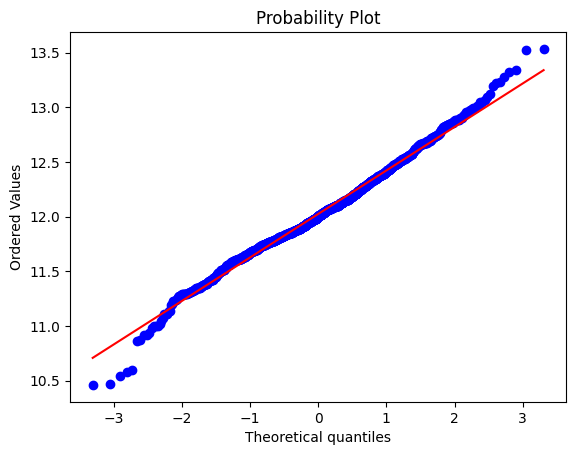

In [12]:
#Este comando aplica la función log(1+x)
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])
y_train = train_data["SalePrice"]

#Comprobamos la nueva distribución
sns.distplot(train_data['SalePrice'] , fit=stats.norm);

# Parámetros normales
(mu, sigma) = stats.norm.fit(train_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Dibujamos la distribución
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

Seguidamente, estudiamos en base a esta cuál es la correlación que muestran el resto de variables numéricas:

<Axes: >

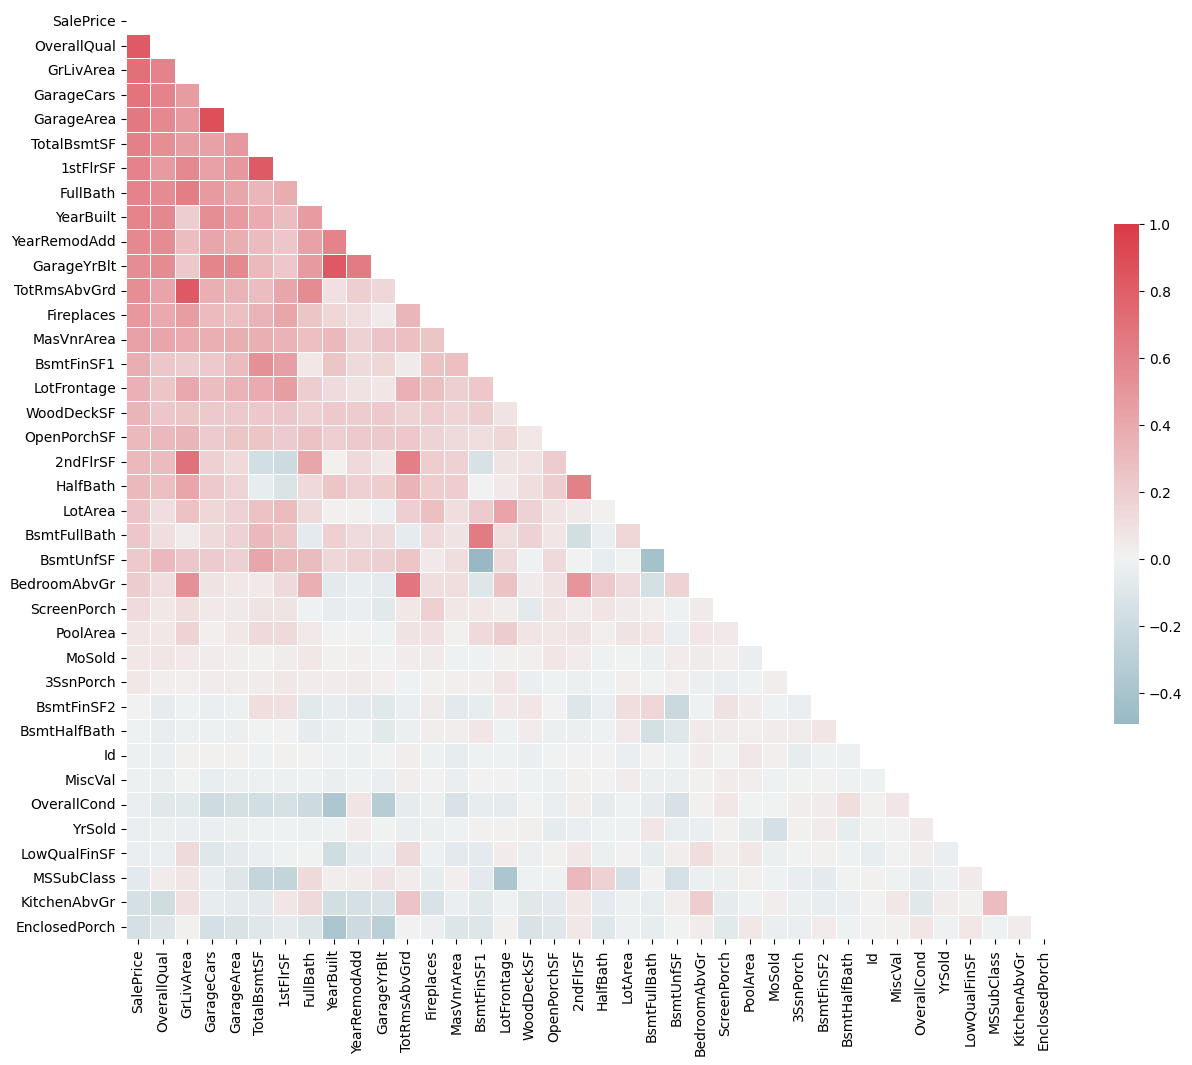

In [13]:
# Select numerical columns
numerical_cols = train_data.select_dtypes(include=[np.number]).columns

# Calculate correlation
corr = train_data[numerical_cols].corr(method = 'pearson').sort_values(by = 'SalePrice', axis = 0, ascending = False).sort_values(by = 'SalePrice', axis = 1, ascending = False)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = False)



En particular, vamos a mostrar un gráfico de las dos variables que mayor correlación poseen con la variable respuesta:


*   OverallQual:



<Axes: xlabel='OverallQual', ylabel='SalePrice'>

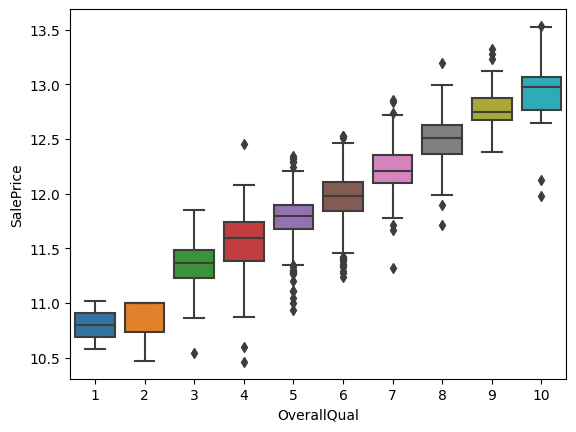

In [14]:
sns.boxplot(data = train_data, x = 'OverallQual', y = 'SalePrice')

 * GrLivArea:


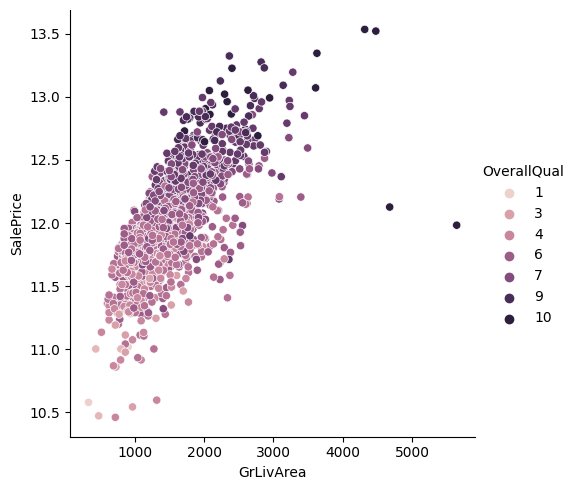

In [15]:
sns.relplot(data = train_data, x = 'GrLivArea', y = 'SalePrice', hue = 'OverallQual')

Sobre este último gráfico (que estudia la variable respuesta frente a la superficie de vivienda) vemos que existen determinados valores que se alejan demasiado del comportamiento asintótico general de la distribución, lo que motiva la introducción del siguiente apartado, en el que en particular se estudian los outliers del dato.

## Valores atípicos
Para esta parte, definiremos dos nuevas variables que nos ayudarán a agrupar las casas, que son el área total de la casa y una discretización de la misma, junto con la calidad general de la casa:

In [16]:
#Área total
dataset['TotalArea'] = dataset['GrLivArea'] + dataset['TotalBsmtSF']
train_data = pd.concat([dataset.loc[dataset.index.isin(train_data.index),:], y_train], axis = 1)
print(train_data[['TotalArea','GrLivArea','TotalBsmtSF','SalePrice']].corr())

             TotalArea  GrLivArea  TotalBsmtSF  SalePrice
TotalArea     1.000000   0.871772     0.826842   0.405827
GrLivArea     0.871772   1.000000     0.445276   0.365294
TotalBsmtSF   0.826842   0.445276     1.000000   0.322029
SalePrice     0.405827   0.365294     0.322029   1.000000


Vemos que la correlación de esta última variable que hemos creado es mejor que sus predecesoras con respecto al precio, por lo que nos quedamos con esta última, y recogemos los cambios en los datos con información de precios disponible

In [17]:
dataset = dataset.drop(['GrLivArea','TotalBsmtSF'], axis = 1)
train_data = pd.concat([dataset.loc[dataset.index.isin(train_data.index),:], y_train], axis = 1)

Discretizamos ahora la superficie total de la casa basándonos en los percentiles 1/3, 2/3 y 0.9. Esta variable se usará simplemente para estudiar valores atípicos y no formará parte del modelo, por lo que la guardamos en un vector aparte:

In [18]:
# Creamos una lista de condicionales
conditions = [
    (train_data['TotalArea'] <= np.quantile(train_data['TotalArea'],0.33)),
    (train_data['TotalArea'] > np.quantile(train_data['TotalArea'],0.33)) & (train_data['TotalArea'] <= np.quantile(train_data['TotalArea'],0.66)),
    (train_data['TotalArea'] > np.quantile(train_data['TotalArea'],0.66)) & (train_data['TotalArea'] <= np.quantile(train_data['TotalArea'],0.9)),
    (train_data['TotalArea'] > np.quantile(train_data['TotalArea'],0.9))
    ]

# Definimos los valores en base a dichos condicionales
values = ['Small', 'Medium', 'Big', 'Huge']

# Creamos la variable discretizada
train_data['TotalAreaDisc'] = np.select(conditions, values)

<Axes: xlabel='TotalAreaDisc', ylabel='SalePrice'>

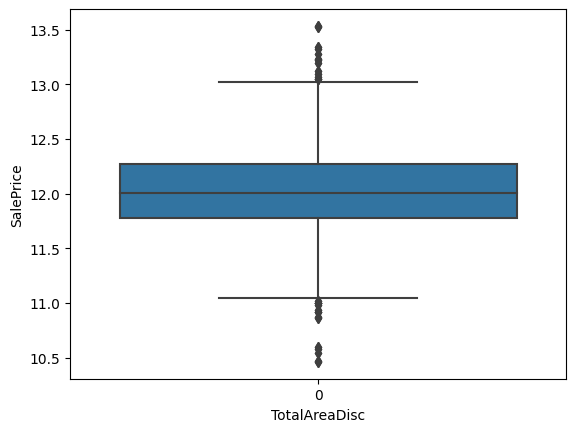

In [19]:
sns.boxplot(data = train_data, x = 'TotalAreaDisc', y = 'SalePrice') 

Finalmente, una vez tenemos la superficie total, tiene sentido estudiar la variable precio por metro cuadrado para ver posibles valores atípicos, y contrastarla con el barrio en el que se localiza la vivienda. Esta variable, de nuevo, es puramente indicativa y no formará parte de nuestros datos:

In [20]:
train_data['PricePerSM'] = (np.exp(train_data['SalePrice'])-1)/train_data['TotalArea']

In [21]:
import plotly.express as px
fig = px.scatter(train_data, x="TotalArea", y="SalePrice" ,size='SalePrice', color="TotalArea", hover_name="TotalArea"  ,log_y=True, size_max=30)
fig.show()


Con el anterior gráfico podemos contemplar de manera muy evidente el objetivo de esta parte del estudio, que es corregir valores atípicos. En él, analizamos la variable que acabamos de definir de precio por unidad de superficie frente  la calidad general de la casa, observando que hay valores particularmente disonantes de precios muy económicos en casas que obtienen una puntuación de diez y además son de las más grandes de la muestra:

In [22]:
def replace_outliers(data, group_variables, label):
  '''
  Parameters
  ----------
  data : pandas.DataFrame
      Object where our data lies.
  group_variables : list
      List where we store the variables we want to take into account when replacing outliers.
  label : list
      List-formatted label.

  Raises
  ------
  numpy.array containing the label column(s) with outliers replaced.
  '''
  data_aux = data
  Q3 = data_aux[group_variables + label].groupby(group_variables).quantile(.75)
  Q1 = data_aux[group_variables + label].groupby(group_variables).quantile(.25)
  IQR = Q3-Q1
  upper_limit = Q3+1.5*IQR
  lower_limit = Q1-1.5*IQR
  upper_limit.columns = [col + '_ul' for col in label]
  lower_limit.columns = [col + '_ll' for col in label]
  data_aux = data_aux.join(upper_limit, on = group_variables, how = 'left')
  data_aux.loc[data_aux.loc[:,label].values[:,0] > data_aux.loc[:,upper_limit.columns].values[:,0],label] = data_aux.loc[data_aux.loc[:,label].values[:,0] > data_aux.loc[:,upper_limit.columns].values[:,0],upper_limit.columns].values
  data_aux = data_aux.join(lower_limit, on = group_variables, how = 'left')
  data_aux.loc[data_aux.loc[:,label].values[:,0] < data_aux.loc[:,lower_limit.columns].values[:,0],label] = data_aux.loc[data_aux.loc[:,label].values[:,0] < data_aux.loc[:,lower_limit.columns].values[:,0],lower_limit.columns].values
  return data_aux.loc[:,label].values

In [23]:
train_data.loc[:,'PricePerSM'] = replace_outliers(train_data, ['OverallQual'], ['PricePerSM'])
train_data.loc[:,'SalePrice'] = np.log1p(train_data.loc[:,'PricePerSM'])*train_data.loc[:,'TotalArea']

*¡Ya no hay outliers!*

/home/deme/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning:

6.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



<Axes: xlabel='OverallQual', ylabel='PricePerSM'>

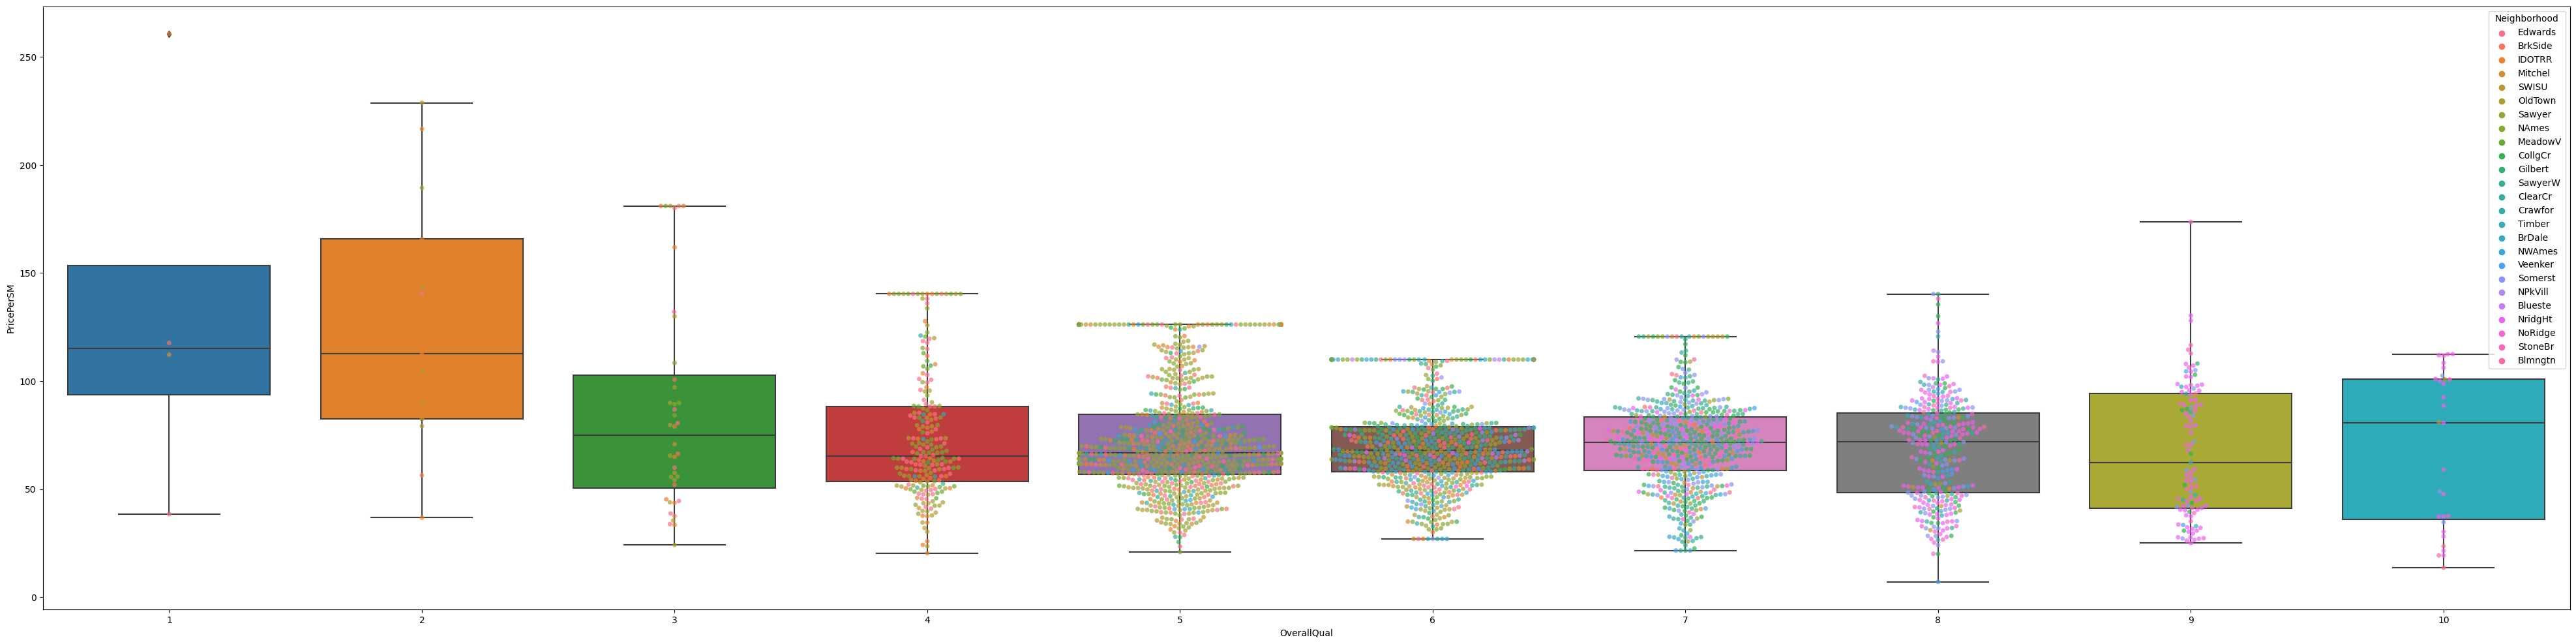

In [24]:
a4_dims = (50, 12)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data = train_data.reset_index(), x = 'OverallQual', y = 'PricePerSM', ax = ax)
sns.swarmplot(data = train_data.reset_index(), x = 'OverallQual', y = 'PricePerSM', hue = 'Neighborhood', alpha = .7)


Eliminamos las variables auxiliares

In [25]:
train_data = train_data.drop(['PricePerSM', 'TotalAreaDisc'], axis = 1)

## Variables altamente correlacionadas

Finalmente, nos disponemos a eliminar del modelo variables que aporten una información linearmente similar al mismo. La lógica será la siguiente:

1.   Analizamos de la matriz de correlación en busca de valores que sean superior a un cierto *threshold* (en nuestro caso, .75)
2.   De entre ambas variables con un índice de correlación tan alto, eliminamos aquella que tenga menor corficiente de correlación con la variable respuesta.





In [26]:
def high_correlated_data(data, label, threshold):
    # Seleccione solo columnas numéricas
    numeric_cols = data.select_dtypes(include=[np.number])

    # Calcule la matriz de correlación y ordénela
    corr = numeric_cols.corr(method = 'pearson')
    corr.sort_values(by = label, axis = 0, ascending = False, inplace=True)
    corr.sort_values(by = label, axis = 1, ascending = False, inplace=True)

    var_out = []
    for idx in range(1, corr.shape[0]): # Descartamos de los índices la propia variable respuesta
        for col in range(idx+1, corr.shape[1]): # Descartamos de las columnas la propia variable respuesta
            if ((corr.iloc[idx,col]>threshold) & (corr.iloc[idx,0]>corr.iloc[0,col])):
                var_out.append(corr.columns[col])
                print('Variables {var1} and {var2} are highly correlated ({corr:.3f}), but since {var1}-label correlation is {corr1:.3f} and {var2}-label correlation is {corr2:.3f}, we get rid of {var2}'.format(var1 = corr.index[idx],var2 = corr.columns[col],corr = corr.iloc[idx,col],corr1 = corr.iloc[idx,0],corr2 = corr.iloc[0,col]))
            elif ((corr.iloc[idx,col]>threshold) & (corr.iloc[idx,0]<corr.iloc[0,col])):
                var_out.append(corr.index[idx])
                print('Variables {var1} and {var2} are highly correlated ({corr:.3f}), but since {var1}-label correlation is {corr1:.3f} and {var2}-label correlation is {corr2:.3f}, we get rid of {var1}'.format(var1 = corr.index[idx],var2 = corr.columns[col],corr = corr.iloc[idx,col],corr1 = corr.iloc[idx,0],corr2 = corr.iloc[0,col]))
            else:
                continue
    return var_out

high_correlated_data(train_data, 'SalePrice', .75)


Variables TotalArea and 1stFlrSF are highly correlated (0.792), but since TotalArea-label correlation is 0.949 and 1stFlrSF-label correlation is 0.741, we get rid of 1stFlrSF
Variables GarageArea and GarageCars are highly correlated (0.890), but since GarageArea-label correlation is 0.574 and GarageCars-label correlation is 0.563, we get rid of GarageCars
Variables YearBuilt and GarageYrBlt are highly correlated (0.835), but since YearBuilt-label correlation is 0.409 and GarageYrBlt-label correlation is 0.389, we get rid of GarageYrBlt


['1stFlrSF', 'GarageCars', 'GarageYrBlt']

In [27]:
#Implementación optimizada
threshold = .75
var_out = [corr.columns[col] if ((corr.iloc[idx,col]>threshold) & (corr.iloc[idx,0]>corr.iloc[0,col])) else corr.index[idx] if ((corr.iloc[idx,col]>threshold) & (corr.iloc[idx,0]<corr.iloc[0,col])) else 0 for idx in range(1,corr.shape[0]) for col in range(idx+1,corr.shape[1])]
var_out = [var for var in var_out if var!=0]
print(var_out)

['TotRmsAbvGrd', 'GarageArea', '1stFlrSF', 'GarageYrBlt']


Eliminamos dichas variables de los datos de entrenamiento, y adaptamos todos los cambios anteriores a los datos test:

In [28]:
#Datos entrenamiento
train_data = train_data.drop(var_out, axis = 1)
X_train = train_data.drop(['SalePrice'], axis = 1)
#Datos test
X_test = dataset.loc[X_test.index,~dataset.columns.isin(var_out)]
#Todo
dataset = pd.concat([X_train, X_test], axis = 0)

## Skewness

Observamos ahora la simetría de las variables numéricas, a fin de aplicar la transformación Box-Cox:

In [29]:
numeric_vars = dataset.select_dtypes(include = ['int', 'float'])
# Check the skew of all numerical features
skewed_feats = numeric_vars.apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head(100))

                    Skew
MiscVal        21.945314
PoolArea       16.896865
LotArea        12.821321
LowQualFinSF   12.087706
3SsnPorch      11.375069
KitchenAbvGr    4.301828
BsmtFinSF2      4.147360
EnclosedPorch   4.003504
ScreenPorch     3.946296
BsmtHalfBath    3.929596
MasVnrArea      2.600971
OpenPorchSF     2.535108
WoodDeckSF      1.834596
TotalArea       1.514895
LotFrontage     1.502371
BsmtFinSF1      1.425466
MSSubClass      1.375275
BsmtUnfSF       0.919151
2ndFlrSF        0.861417
Fireplaces      0.733253
HalfBath        0.695091
BsmtFullBath    0.624216
OverallCond     0.570476
BedroomAbvGr    0.326385
OverallQual     0.196806
MoSold          0.195827
FullBath        0.167295
YrSold          0.132469
GarageCars     -0.218641
YearRemodAdd   -0.451420
YearBuilt      -0.599866


In [30]:
from scipy.special import boxcox1p
import numpy as np

skewness = skewness.loc[abs(skewness.Skew) > 0.75,:] 
lambda_values = pd.Series(np.linspace(-2,2,40)) 

for var in skewness.index:
    if not np.any(np.isnan(dataset[var])) and dataset[var].dtype.kind in 'bifc': # check if variable is numeric and not NaN
        median_value = dataset[var].median()
        skews = [stats.skew(boxcox1p(dataset[var].fillna(median_value), lam)) for lam in lambda_values] # fill NaN values with median before calculation
        if not np.isnan(skews).all(): # check if skews is not all NaN
            lam = lambda_values[pd.Series(np.abs(skews)).idxmin()] 
            dataset[var] = boxcox1p(dataset[var].fillna(median_value), lam) # fill NaN values with median before calculation
        else:
            print(f"Variable {var} returned all NaN skews")
    else:
        print(f"Variable {var} is not numeric or contains NaN values")



Variable BsmtFinSF2 is not numeric or contains NaN values
Variable BsmtHalfBath is not numeric or contains NaN values
Variable MasVnrArea is not numeric or contains NaN values
Variable TotalArea is not numeric or contains NaN values
Variable LotFrontage is not numeric or contains NaN values
Variable BsmtFinSF1 is not numeric or contains NaN values
Variable BsmtUnfSF is not numeric or contains NaN values


In [31]:
from scipy import stats

skewness = skewness.loc[abs(skewness.Skew) > 0.75,:] 
lambda_values = pd.Series(np.linspace(-2,2,40)) 

# Imputar los valores NaN con la mediana antes de comenzar la transformación
for var in skewness.index:
    if dataset[var].isnull().any():  # Comprueba si la variable tiene algún valor NaN
        dataset[var].fillna(dataset[var].median(), inplace=True)  # Llena los valores NaN con la mediana

for var in skewness.index:
    if dataset[var].dtype.kind in 'bifc': # check if variable is numeric
        skews = [stats.skew(boxcox1p(dataset[var], lam)) for lam in lambda_values] # calculate skews
        if not np.isnan(skews).all(): # check if skews is not all NaN
            lam = lambda_values[pd.Series(np.abs(skews)).idxmin()] 
            dataset[var] = boxcox1p(dataset[var], lam) 
        else:
            print(f"Variable {var} returned all NaN skews")
    else:
        print(f"Variable {var} is not numeric")




## Codificado de variables categóricas

Ahora, a las variables que se corresponden con objetos les asignamos una numeración para que sean interpretables por el modelo. Este hecho va asociado en primer lugar a que hay algunas variables que se interpretan como numéricas y que, sin embargo, no se deben tratar como tal

In [32]:
#Variables numéricas que no deben tratarse como tal
dataset['MSSubClass'] = dataset['MSSubClass'].apply(str)
dataset['YrSold'] = dataset['YrSold'].astype(str)
dataset['MoSold'] = dataset['MoSold'].astype(str)

Por una parte, de las que se puede inferir un cierto orden, se codificarán de manera más reducida con un *LabelEncoder()*

In [33]:
from sklearn.preprocessing import LabelEncoder #Librería
LabelEncoderCols = ['BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional','BsmtExposure', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street',  'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for col in LabelEncoderCols:
    encoder = LabelEncoder() 
    dataset.loc[:,[col]] = encoder.fit_transform(dataset[col])

Por otra parte, de las que no se deduzca orden concreto, usamos *OneHotEncoder()*

In [34]:
from sklearn.preprocessing import OneHotEncoder 
obj_vars = dataset.select_dtypes(include = 'object').columns
encoder = OneHotEncoder() 
for var in obj_vars: 
  encoder.fit(dataset.loc[:,[var]])
  enc_data = pd.DataFrame(
      encoder.transform(dataset.loc[:,[var]]).toarray(), 
      columns = [var + '_' + str(typevar) for typevar in encoder.categories_[0].tolist()], 
      index = dataset.index
  )
  dataset = pd.concat([dataset, enc_data], axis = 1)
  dataset = dataset.drop([var], axis = 1)


# Modelización

A continuación, pasamos a estudiar los modelos predictivos que serán la forma de elaborar estimaciones de precios de viviendas, dado un cierto *input*

In [35]:
for column in ['SalePrice', 'TotRmsAbvGrd', 'GarageArea', '1stFlrSF', 'GarageYrBlt']:
    if column in train_data.columns:
        print(f'La columna {column} existe en train_data.')
    else:
        print(f'La columna {column} NO existe en train_data.')


La columna SalePrice existe en train_data.
La columna TotRmsAbvGrd NO existe en train_data.
La columna GarageArea NO existe en train_data.
La columna 1stFlrSF NO existe en train_data.
La columna GarageYrBlt NO existe en train_data.


In [36]:
# Datos de entrenamiento
X_train = train_data.drop('SalePrice', axis=1)
y_train = train_data['SalePrice']

# Datos de prueba
X_test = dataset.loc[X_test.index, dataset.columns != 'SalePrice']

# Todo
dataset = pd.concat([X_train, X_test], axis=0)




In [39]:
# Importación de librerías
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Escalado de datos
scaler = StandardScaler()

# Asegúrate de que tus datos están en el formato correcto (pandas DataFrame)
# Esto es importante porque usamos operaciones específicas de DataFrame más adelante
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Asegurándose de que las longitudes sean las mismas
print(len(X_train))
print(len(y_train))

# Imprimir los índices de X_train
print(X_train.index)

# Escalando los datos
scaler.fit(dataset)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Imprimir los índices de X_train después de la transformación
print(X_train_scaled.index)

# Partición de datos de entrenamiento para analizar modelos
n_splits = 8
kf = KFold(n_splits=n_splits)

# Diccionario de modelos
models = {'OLS': LinearRegression(),
          'SVR': SVR(),
          'Ridge': Ridge(),
          'Lasso': Lasso(),
          'ElasticNet': ElasticNet(),
          'RandomForest': RandomForestRegressor(),
          'XGB': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)
         }

# Bucle para probar cada modelo
for name, model in models.items():
  print('Probamos modelo {}:'.format(name))
  rsme = []
  for train_idx, test_idx in kf.split(X_train_scaled, y_train):
    model.fit(X_train_scaled.iloc[train_idx,:], y_train.iloc[train_idx])
    y_pred = np.expm1(model.predict(X_train_scaled.iloc[test_idx,:]))
    rsme.append(np.sqrt(sum((np.expm1(y_train.iloc[test_idx])-y_pred)**2)))
  print('El RMSE medio de las estimaciones es: {:.2f}'.format(np.mean(rsme)))


29181
2919
RangeIndex(start=0, stop=29181, step=1)


/home/deme/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/deme/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



RangeIndex(start=0, stop=29181, step=1)
Probamos modelo OLS:


ValueError: Found input variables with inconsistent numbers of samples: [29181, 2919]